# Rearrange files

# Config

In [1]:
import os

In [2]:
# import conversion tools
from tools.conv_tools import tools as ctools
from tools.conv_tools import ter
ter

Tools converting in the following extensions:
('pdf', 'png')
('[img]', 'pdf')
('png', 'txt')
('pdf', 'txt')
('pdf', 'txt')
('pdf', 'txt')
('pdf', 'txt')
('pdf', 'txt')


{'pdf2img': 'pdf',
 'img2pdf': '[img]',
 'pytesseract_ocr': 'png',
 'PyPDF4_ocr': 'pdf',
 'pdfminer_ocr': 'pdf',
 'tika_ocr': 'pdf',
 'pdfreader_ocr': 'pdf',
 'grobid_extr': 'pdf'}

In [3]:
tools_for_conversion = ['pdfreader_ocr','pytesseract_ocr','tika_ocr','pdfminer_ocr','PyPDF4_ocr']

# Load and Rearrange Files

In [4]:
from tools.utils import *

[nltk_data] Downloading package words to /home/lubrini/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [5]:
data_path = os.path.join('data')

input_path = os.path.join(data_path, 'docs')

ref_dir = 'ref'               # name of the directory where reference txt is stored 

doc_paths = [os.path.join(input_path, filepath) for filepath in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, filepath))]


In [6]:
## convert images to pdf
not_pdf_filepaths = [doc_path for doc_path in doc_paths if not doc_path.endswith('.pdf')]
for doc_path in not_pdf_filepaths:
    try:
        ctools.img2pdf(doc_path)
    except:
        print(doc_path)
        print('Warning: "{0}" extension not supported for conversion to pdf'.format(doc_path[:-4]))

In [7]:
## move files from input_path to their own directory
for doc_path in doc_paths:
    mv_to_custom_dir(doc_path)
    

In [8]:
## rename files that do not have (usable) text embedded
lang_threshold = 0.90 # min percentage of words that need to be in a vocabulary for the embedded text to be considered usable
embedded_text_dir='embedded_txt'

for doc_dir in os.listdir(input_path):
    dir_path = os.path.join(input_path,doc_dir)
    for file_or_tool_name in os.listdir(dir_path):
        file_or_tool_path = os.path.join(dir_path,file_or_tool_name)
        if os.path.isfile(file_or_tool_path) and file_or_tool_path.endswith('pdf'):
            doc_path = file_or_tool_path 
            print('file_paths:',doc_path)

            # check if text is already embedded
            text = get_emb_txt(doc_path)
            if text != '':
                
                prep_text, doc_wordlist = prep_and_tokenise(text) # tokenise and preprocess text

                # get language of text
                languages = get_langs(prep_text)
                
                lang_wordlist_paths = {lang_code:os.path.join(data_path, 'wordlists',(lang_code+'.txt')) for lang_code in languages}
                print('languages:',languages)
                multilang_score = words_in_langs_ratio(doc_wordlist=doc_wordlist,
                                    languages=languages,
                                    max_n_words=50,
                                    lang_wordlist_paths=lang_wordlist_paths
                                    )

                if multilang_score < lang_threshold: # if not enough words are part of the language...
                    print('SCORE:',multilang_score)
                    print('Text is not usable! Score too low.')

                    unusable_path = os.path.join(dir_path,('UNUSABLE'+embedded_text_dir))
                    os.makedirs(unusable_path, exist_ok=True)
                    with open(os.path.join(unusable_path,'unusable_emb.txt'), 'w+') as f:
                        f.write(text)
                    mark_filename(file_path=doc_path,mark='_no-emb-txt_') # ...call function to mark filename as not having usable embedded text
                    
                else:
                    print('SCORE:',multilang_score)
                    print('Score is equal or more than threshold. Embedded text will be stored in a subdirectory of the document\'s directory.')
                    embedded_text_dir_path = os.path.join(dir_path,embedded_text_dir)
                    os.makedirs(embedded_text_dir_path, exist_ok=True)
                    embedded_text_path = os.path.join(embedded_text_dir_path,'emb.txt')
                    with open(embedded_text_path, 'w+') as f:
                        f.write(text)

            # if no text available, rename doc
            else:
                print('No text available!')
                mark_filename(file_path=doc_path,mark='_no-emb-txt_')

file_paths: data/docs/flyer_coleottero_giapponese/flyer_coleottero_giappone_zone_misure.pdf
languages: ['it']


100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


COUNT (spellchecker): 38
SCORE: 0.76
Text is not usable! Score too low.
Marking filename...
file_paths: data/docs/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie.pdf
languages: ['nl']


100%|██████████| 1/1 [00:07<00:00,  7.63s/it]


COUNT (spellchecker): 35
SCORE: 0.7
Text is not usable! Score too low.
Marking filename...
file_paths: data/docs/footnote/footnote.pdf
languages: ['sv']


100%|██████████| 1/1 [00:07<00:00,  7.04s/it]

COUNT (spellchecker): 27
SCORE: 0.54
Text is not usable! Score too low.
Marking filename...
file_paths: data/docs/sample_no_txt/sample_no_txt.pdf


languages: ['de']


100%|██████████| 1/1 [00:11<00:00, 11.67s/it]

COUNT (spellchecker): 19
SCORE: 0.38
Text is not usable! Score too low.
Marking filename...


In [9]:
#create labels
for doc_dir in os.listdir(input_path):
    dir_path = os.path.join(input_path,doc_dir)
    ref_path = os.path.join(dir_path,ref_dir)
    if not os.path.exists(ref_path):            # create ref dir if doesn't exist
        os.mkdir(ref_path)
        
        # add labels to their document's path
        for txt_file in os.listdir(dir_path):
            if txt_file.endswith('.txt'):
                os.rename(os.path.join(dir_path,txt_file),os.path.join(ref_path,txt_file))
    
    # create empty ref file if it doesn't exist
    if not os.listdir(ref_path):
        open(os.path.join(ref_path,'label_ref.txt'), 'w+').close()   


# Conversion and Evaluation

In [10]:
from tools.conv_tools import conv_ad_save
from tools.conv_classes import Doc, TxtConverter
from tools.eval_tools import get_cer

In [11]:
# create convertor instance from class
converter = TxtConverter(tools=ctools)

In [12]:
# for doc in data (each doc has its own directory)
print('Input_path:', input_path) 
cers = {} # CER scores
las = {}

for dir in os.listdir(input_path):
    dir_path = os.path.join(input_path,dir)
    print('dir_path:',dir_path)
    
    doc_paths = [os.path.join(dir_path, filepath) for filepath in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, filepath))]
    print('doc_paths:',doc_paths)
    # create Doc instance with doc path
    doc_object = Doc(doc_paths, tools=ctools)
    print('doc_object:',doc_object)

        
    ## CONVERSION
    conv_ad_save(dir_path,
            doc_object,
            converter,
            tool_names=tools_for_conversion,
            overwrite=False) # set to True to overwrite previous conversion exports
    embedded_text_path = os.path.join(dir_path, embedded_text_dir)
    if os.path.exists(embedded_text_path) and [filename.endswith('.txt') for filename in os.listdir(embedded_text_path)]:
        emb_dir = os.path.join(dir_path,embedded_text_dir)
        print('emb_dir:',emb_dir)
        emb_file = [os.path.join(emb_dir,file) for file in os.listdir(emb_dir)][0]
        with open(emb_file) as f:
            embedded_text = f.read()
        doc_object.data['txt'].update(dict(embedded_text_dir=embedded_text))
    

    ## GET METADATA
    print('DATA',doc_object.data['txt'].keys())
    if doc_object.data['txt']['embedded_text_dir']:
            text = doc_object.data['txt']['embedded_text_dir']
    else: doc_object.data['txt']['pytesseract_ocr']
    prep_text,_ = prep_and_tokenise(text)
    doc_object.get_metadata(prep_text)
    lang_codes = doc_object.metadata['lang_codes']
    print(lang_codes)
    # TODO store metadata in dir_path/meta.jason
        
    ## EVALUATION 
        # (1) Language Accuracy
    las[doc_path] = {}
    for lang_code in lang_codes:
        las[doc_path][lang_code] = {}
        txt_convs = doc_object.data['txt']
        tools = txt_convs.keys()
        for tool in tools:
            _,doc_wordlist = prep_and_tokenise(txt_convs[tool])
            la = words_in_lang_ratio(doc_wordlist,
                                    lang_code,
                                    lang_wordlist=[],
                                    lang_wordlist_path='',
                                    max_n_words=100)
            las[doc_path][lang_code][tool]=la


        # (2) Character Error Rate 
    doc_cer = get_cer(cers,
            doc_object,
            dir_path,
            ref_dir,
            source='obj')
            
    cers.update(doc_cer)
    #else:
    #print('Embedded text already exists for', dir)

print('Character Error Rates', cers)
print('Language Accuracy', las)

Input_path: data/docs
dir_path: data/docs/flyer_coleottero_giapponese
doc_paths: ['data/docs/flyer_coleottero_giapponese/flyer_coleottero_giappone_zone_misure.pdf']
doc_object: <tools.conv_classes.Doc object at 0x7f145ee647c0>
Converting: data/docs/flyer_coleottero_giapponese
{'original': [<_io.BufferedReader name='data/docs/flyer_coleottero_giapponese/flyer_coleottero_giappone_zone_misure.pdf'>]}
tool_selection.keys() dict_keys(['PyPDF4_ocr', 'pdfminer_ocr', 'tika_ocr', 'pdfreader_ocr', 'grobid_extr', 'pytesseract_ocr'])
tool_names ['pdfreader_ocr', 'pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr']


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


emb_dir: data/docs/flyer_coleottero_giapponese/embedded_txt
DATA dict_keys(['pdfreader_ocr', 'pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr', 'embedded_text_dir'])
['it']
COUNT (spellchecker): 91
COUNT (spellchecker): 71
COUNT (spellchecker): 75
COUNT (spellchecker): 76
COUNT (spellchecker): 75
COUNT (spellchecker): 76
dir_path: data/docs/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie
doc_paths: ['data/docs/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie.pdf']
doc_object: <tools.conv_classes.Doc object at 0x7f144b00fca0>
Converting: data/docs/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie
{'original': [<_io.BufferedReader name='data/docs/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie.pdf'>]}
tool_selection.keys() dict_keys(['PyPDF4_ocr', 'pdfminer_ocr', 'tika_ocr', 'pdfreader_ocr', 'grobid_extr', 'pytesseract_ocr'])
tool_names ['pdfreader_ocr', 'pytesse

 20%|██        | 1/5 [00:00<00:00,  6.75it/s]

Value Error


100%|██████████| 5/5 [00:32<00:00,  6.42s/it]


emb_dir: data/docs/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie/embedded_txt
DATA dict_keys(['pdfreader_ocr', 'pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr', 'embedded_text_dir'])
['nl']
COUNT (spellchecker): 0
COUNT (spellchecker): 59
COUNT (spellchecker): 68
COUNT (spellchecker): 68
COUNT (spellchecker): 66
COUNT (spellchecker): 68
dir_path: data/docs/footnote
doc_paths: ['data/docs/footnote/footnote.pdf']
doc_object: <tools.conv_classes.Doc object at 0x7f144ac2a550>
Converting: data/docs/footnote
{'original': [<_io.BufferedReader name='data/docs/footnote/footnote.pdf'>]}
tool_selection.keys() dict_keys(['PyPDF4_ocr', 'pdfminer_ocr', 'tika_ocr', 'pdfreader_ocr', 'grobid_extr', 'pytesseract_ocr'])
tool_names ['pdfreader_ocr', 'pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr']


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


emb_dir: data/docs/footnote/embedded_txt
DATA dict_keys(['pdfreader_ocr', 'pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr', 'embedded_text_dir'])
['sv']
COUNT (spellchecker): 82
COUNT (spellchecker): 51
COUNT (spellchecker): 56
COUNT (spellchecker): 52
COUNT (spellchecker): 48
COUNT (spellchecker): 55
dir_path: data/docs/sample_no_txt
doc_paths: ['data/docs/sample_no_txt/sample_no_txt.pdf']
doc_object: <tools.conv_classes.Doc object at 0x7f14498529a0>
Converting: data/docs/sample_no_txt
{'original': [<_io.BufferedReader name='data/docs/sample_no_txt/sample_no_txt.pdf'>]}
tool_selection.keys() dict_keys(['PyPDF4_ocr', 'pdfminer_ocr', 'tika_ocr', 'pdfreader_ocr', 'grobid_extr', 'pytesseract_ocr'])
tool_names ['pdfreader_ocr', 'pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr']


100%|██████████| 5/5 [01:07<00:00, 13.53s/it]


emb_dir: data/docs/sample_no_txt/embedded_txt
DATA dict_keys(['pdfreader_ocr', 'pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr', 'embedded_text_dir'])
['de']
COUNT (spellchecker): 6
COUNT (spellchecker): 23
COUNT (spellchecker): 27
COUNT (spellchecker): 28
COUNT (spellchecker): 28
COUNT (spellchecker): 27
Character Error Rates {'flyer_coleottero_giappone_zone_misure.pdf': {'pdfreader_ocr': 78108.0, 'pytesseract_ocr': 20484.0, 'tika_ocr': 21844.0, 'pdfminer_ocr': 21128.0, 'PyPDF4_ocr': 20520.0, 'embedded_text_dir': 21012.0}, '1954_blöte_cacopsylla_pruni_pays-bas_hollande_copie.pdf': {'pdfreader_ocr': 100.0, 'pytesseract_ocr': 240615.3846, 'tika_ocr': 259815.3846, 'pdfminer_ocr': 272553.8462, 'PyPDF4_ocr': 334476.9231, 'embedded_text_dir': 260338.4615}, 'footnote.pdf': {'pdfreader_ocr': 239400.0, 'pytesseract_ocr': 17376.9231, 'tika_ocr': 19023.0769, 'pdfminer_ocr': 21715.3846, 'PyPDF4_ocr': 22500.0, 'embedded_text_dir': 18738.4615}, 'sample_no_txt.pdf': {'pdfreader_ocr': 330.

# Evaluation from converted txt files
(to be used if conversion outputs have already been saved)

In [13]:
x = ['ammmma', 'fqefqfze', 'io']
true_counter(func=in_lang_sc, elems=x, lang_code='it')

1

In [14]:
## SCORE (1) Character Error Rate
cers = {}
for dir in os.listdir(input_path):
    dir_path = os.path.join(input_path,dir)
    doc_paths = [os.path.join(dir_path, filepath) for filepath in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, filepath))]
    
    # create Doc instance with doc path
    doc_object = Doc(doc_paths, tools=ctools)

    cers = get_cer(cers,
                    doc_object,
                    dir_path,
                    ref_dir,
                    source='file')

In [15]:
## SCORE (2) language accuracy
'''las = {}
for dir in os.listdir(input_path):
    dir_path = os.path.join(input_path,dir)
    doc_paths = [os.path.join(dir_path, filepath) for filepath in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, filepath))]
    
    # create Doc instance with doc path
    doc_object = Doc(doc_paths, tools=ctools)
    
    las = get_la(las,
                    doc_object,
                    dir_path,
                    ref_dir,
                    source='file')
                    
def get_la=(las,
            doc_object,
            dir_path,
            metadata,
            ref_dir,
            source='file')'''

"las = {}\nfor dir in os.listdir(input_path):\n    dir_path = os.path.join(input_path,dir)\n    doc_paths = [os.path.join(dir_path, filepath) for filepath in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, filepath))]\n    \n    # create Doc instance with doc path\n    doc_object = Doc(doc_paths, tools=ctools)\n    \n    las = get_la(las,\n                    doc_object,\n                    dir_path,\n                    ref_dir,\n                    source='file')\n                    \ndef get_la=(las,\n            doc_object,\n            dir_path,\n            metadata,\n            ref_dir,\n            source='file')"

# Visualisation

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# sum up scores per tools
cer_per_tool = {}

for _,tool_cer in cers.items():
    for tool,cer in tool_cer.items():
        cer_per_tool[tool] = 0   
    break
        
for _,tool_cer in cers.items():
    for tool,cer in tool_cer.items():
        cer_per_tool[tool] = cer_per_tool[tool]+cer

cer_per_tool


{'pdfreader_ocr': 317938.7692,
 'embedded_txt': 947973.5384,
 'PyPDF4_ocr': 1066989.2308,
 'pdfminer_ocr': 1051712.6154,
 'tika_ocr': 973851.6923,
 'UNUSABLEembedded_txt': 947973.5384,
 'pytesseract_ocr': 907691.6923}

In [18]:
# sum up scores per tools
la_per_tool = {}

for _,lang_d in las.items():
    for _,tool_d in lang_d.items():
        for tool,_ in tool_d.items():
            la_per_tool[tool] = 0
        break
    break
        
for _,lang_d in las.items():
    for _,tool_d in lang_d.items():
        for tool,la in tool_d.items():
            la_per_tool[tool] = la_per_tool[tool]+la

la_per_tool


{'pdfreader_ocr': 0.8571428571428571,
 'pytesseract_ocr': 0.23,
 'tika_ocr': 0.27,
 'pdfminer_ocr': 0.28,
 'PyPDF4_ocr': 0.28,
 'embedded_text_dir': 0.27}

In [19]:
data = la_per_tool

<AxesSubplot:>

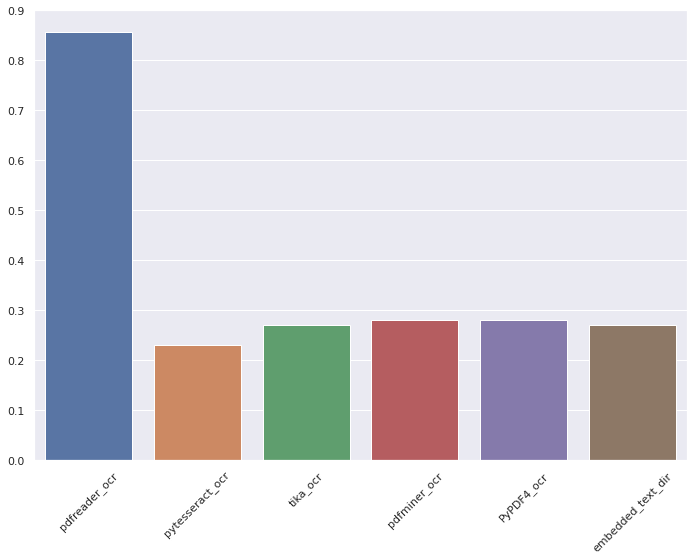

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=45)
sns.barplot(x=list(data.keys()), y=list(data.values()))

In [24]:
from tools.conv_tools import grobid_extr
grobid_extr('/home/lubrini/GitHub/psylloidea_ontology/img2txt/data/docs/sample_no_txt/sample_no_txt.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'cd'